# <img src="https://upload.wikimedia.org/wikipedia/commons/6/60/NISAR_artist_concept.jpg" width=400 align="left"/>
<img src="https://upload.wikimedia.org/wikipedia/commons/9/9b/NISAR_Mission_Logo.png" width=400 align="left"/><br><br><br><br><br>



# Convert ALOS-2 Data to GCOV

In preparation for NISAR, this notebook does:
- ALOS-2 L1.1 (must be StripMap) to NISAR RSLC with https://github.com/isce-framework/isce3/blob/develop/share/nisar/examples/alos2_to_nisar_l1.py
- NISAR DEM staging with https://github.com/isce-framework/isce3/blob/develop/python/packages/nisar/workflows/stage_dem.py 
- NISAR RSLC to GCOV with and https://github.com/isce-framework/isce3/blob/develop/python/packages/nisar/workflows/gcov.py


Requirements:
- a CPU or GPU instance in the On-Demand System 
- updated ISCE3 repo and installed isce3_src or isce3_src_CPU conda environment
- notebook kernel set to isce3_src or isce3_src_CPU


for questions/feedback, contact Alex Christensen

In [1]:
import os
import sys
from pathlib import Path
import subprocess
import fnmatch
import zipfile
import h5py
from string import Template
from osgeo import gdal
import numpy as np
import math
import boto3
import shutil
import matplotlib.pyplot as plt
import imageio
import asf_search as asf
from shapely import Polygon
import json
import glob
import pandas as pd

from yaml import safe_load, safe_dump


## Set directories

Files should not be stored in scratch after processing due to costs. Files will be moved to the S3 bucket after processing. 

In [2]:
notebook_dir = Path(os.getcwd())
working_dir = Path('/scratch/alex_eco_test/') ## set to your own scratch space 

HOME_DIR = os.environ['HOME']
ISCE3_BUILD_DIR = os.environ.get('ISCE3_BUILD_DIR', f'{HOME_DIR}/isce3/build')

Currently, ALOS-2 zip files are saved to nisar-st-data-ondemand/ALOS2_zip/ and all processed files (RSLC, GCOV, DEMs, etc) are moved to nisar-st-data-ondemand/ALOS2_processed/ at the end of the notebook.

In [3]:
bucket_name = "nisar-st-data-ondemand"
s3_path = 'ALOS2_zip/'
s3 = boto3.client("s3")
response = s3.list_objects_v2(
            Bucket=bucket_name,
            Prefix = s3_path)
contents = response.get('Contents')
existing_ALOS2_zipfiles = [contents[i].get('Key').split('/')[-1] for i in range(len(contents)) if '.zip' in contents[i].get('Key')]
existing_ALOS2_zippaths = [contents[i].get('Key') for i in range(len(contents)) if '.zip' in contents[i].get('Key')]


## Choose your AOI

New directories will be made to store files for this AOI.
For ALOS1, naming conventions are flexible.
For ALOS2, AOI names must match the "Request" name in the ALOS2 ASF Spreadsheet


In [4]:
aoi = 'Mount St. Helens'
sheet = 'Hazards (L1.1)'

aoi_str = aoi.replace(" ", "_")

aoi_dir = working_dir/aoi_str
ALOS2_dir = aoi_dir / 'ALOS2'


## Get the ALOS2 URLs 

If you install **openpyxl**  to your isce3 environment, you can search the ALOS2 spreadsheed directly. Otherwise, you need to copy the list of URLS manually



In [5]:
xlsx = pd.ExcelFile('/scratch/alex_eco_test/ALOS-2_Restricted_Available_at_ASF_20231227.xlsx')
df = pd.read_excel(xlsx,sheet)


Filter the ALOS2 data using name, path, frame, etc

In [7]:
df_filtered = df[df['Request']==aoi]

## Filter if more than one path
paths = df_filtered.groupby('Path').size()
path = int(input('Which path to process? %s' %(paths.index.values)))
df_filtered = df_filtered[df_filtered['Path']==path]

## Filter if more than one frame
frames = df_filtered.groupby('Frame').size()
frame = int(input('Which frame to process? %s' %(frames.index.values)))
df_filtered = df_filtered[df_filtered['Frame']==frame]

frame_dir = aoi_dir / str(path) / str(frame) 

## Filter if more than one Beam
beams = df_filtered.groupby('Beam').size()
if len(np.unique(beams.index.values)) >1:
    beam = input('Which Beam to process? %s' %(beams.index.values))
    df_filtered = df_filtered[df_filtered['Beam']==beam]
    frame_dir = aoi_dir / str(path) / str(frame) / str(beam)
    
else:
    beam = beams.index.values[0]
    frame_dir = aoi_dir / str(path) / str(frame) #/ str(beam)
    
print('Working directory for Path %s, Frame %s, Beam %s is %s' %(path, frame, beam, frame_dir))



Which path to process? [ 67 171] 67
Which frame to process? [910 920] 910


Working directory for Path 67, Frame 910, Beam F2-6 is /scratch/alex_eco_test/Mount_St._Helens/67/910


In [50]:
RSLC_dir = frame_dir / 'RSLC'
DEM_dir = frame_dir / 'DEM'
GCOV_dir = frame_dir / 'GCOV'
TMP_dir = frame_dir / 'TMP'

Path(frame_dir).mkdir(parents=True, exist_ok=True)
Path(RSLC_dir).mkdir(parents=True, exist_ok=True)
Path(ALOS2_dir).mkdir(parents=True, exist_ok=True)
Path(DEM_dir).mkdir(parents=True, exist_ok=True)
Path(GCOV_dir).mkdir(parents=True, exist_ok=True)
Path(TMP_dir).mkdir(parents=True, exist_ok=True)


In [51]:
list_of_ALOS_SLCs = list(df_filtered['Zip Link'])
list_of_ALOS_SLCs.sort()
list_of_ALOS_SLCs

['https://cumulus.asf.alaska.edu/L1.1/A4/0000436021_001001_ALOS2402350910-211104.zip',
 'https://cumulus.asf.alaska.edu/L1.1/A4/0000437308_001001_ALOS2404420910-211118.zip',
 'https://cumulus.asf.alaska.edu/L1.1/A4/0000461338_001001_ALOS2410630910-211230.zip',
 'https://cumulus.asf.alaska.edu/L1.1/A4/0000461340_001001_ALOS2408560910-211216.zip',
 'https://cumulus.asf.alaska.edu/L1.1/A4/0000461343_001001_ALOS2406490910-211202.zip',
 'https://cumulus.asf.alaska.edu/L1.1/A4/0000463917_001001_ALOS2418910910-220224.zip',
 'https://cumulus.asf.alaska.edu/L1.1/A4/0000471584_001001_ALOS2431330910-220519.zip',
 'https://cumulus.asf.alaska.edu/L1.1/A4/0000472578_001001_ALOS2433400910-220602.zip',
 'https://cumulus.asf.alaska.edu/L1.1/A4/0000473046_001001_ALOS2437540910-220630.zip',
 'https://cumulus.asf.alaska.edu/L1.1/A4/0000474582_001001_ALOS2439610910-220714.zip',
 'https://cumulus.asf.alaska.edu/L1.1/A4/0000475154_001001_ALOS2441680910-220728.zip',
 'https://cumulus.asf.alaska.edu/L1.1/A4/00

Or manually enter the list of URLs to download. You can only process one frame at a time since the workflow assumes all images are in a stack

In [9]:
## Example using Mount St. Helens

# list_of_ALOS_SLCs = ['https://cumulus.asf.alaska.edu/L1.1/A4/0000436021_001001_ALOS2402350910-211104.zip',
                     # 'https://cumulus.asf.alaska.edu/L1.1/A4/0000437308_001001_ALOS2404420910-211118.zip',
                     # 'https://cumulus.asf.alaska.edu/L1.1/A4/0000461338_001001_ALOS2410630910-211230.zip',
                     # 'https://cumulus.asf.alaska.edu/L1.1/A4/0000461340_001001_ALOS2408560910-211216.zip',
                     # 'https://cumulus.asf.alaska.edu/L1.1/A4/0000461343_001001_ALOS2406490910-211202.zip',
                     # 'https://cumulus.asf.alaska.edu/L1.1/A4/0000463917_001001_ALOS2418910910-220224.zip',
                     # 'https://cumulus.asf.alaska.edu/L1.1/A4/0000471584_001001_ALOS2431330910-220519.zip',
                     # 'https://cumulus.asf.alaska.edu/L1.1/A4/0000472578_001001_ALOS2433400910-220602.zip',
                     # 'https://cumulus.asf.alaska.edu/L1.1/A4/0000473046_001001_ALOS2437540910-220630.zip',
                     # 'https://cumulus.asf.alaska.edu/L1.1/A4/0000474582_001001_ALOS2439610910-220714.zip',
                     # 'https://cumulus.asf.alaska.edu/L1.1/A4/0000475154_001001_ALOS2441680910-220728.zip',
                     # 'https://cumulus.asf.alaska.edu/L1.1/A4/0000477578_001001_ALOS2443750910-220811.zip',
                     # 'https://cumulus.asf.alaska.edu/L1.1/A4/0000481610_001001_ALOS2447890910-220908.zip',
                     # 'https://cumulus.asf.alaska.edu/L1.1/A4/0000483191_001001_ALOS2449960910-220922.zip',
                     # 'https://cumulus.asf.alaska.edu/L1.1/A4/0000487636_001001_ALOS2456170910-221103.zip',
                     # 'https://cumulus.asf.alaska.edu/L1.1/A4/0000489515_001001_ALOS2458240910-221117.zip',
                     # 'https://cumulus.asf.alaska.edu/L1.1/A4/0000493656_001001_ALOS2460310910-221201.zip',
                     # 'https://cumulus.asf.alaska.edu/L1.1/A4/0000495712_001001_ALOS2462380910-221215.zip',
                     # 'https://cumulus.asf.alaska.edu/L1.1/A4/0000497485_001001_ALOS2464450910-221229.zip',
                     # 'https://cumulus.asf.alaska.edu/L1.1/A4/0000500109_001001_ALOS2466520910-230112.zip',
                     # 'https://cumulus.asf.alaska.edu/L1.1/A4/0000501934_001001_ALOS2468590910-230126.zip',
                     # 'https://cumulus.asf.alaska.edu/L1.1/A4/0000503248_001001_ALOS2470660910-230209.zip',
                     # 'https://cumulus.asf.alaska.edu/L1.1/A4/0000504645_001001_ALOS2472730910-230223.zip',
                     # 'https://cumulus.asf.alaska.edu/L1.1/A4/0000505511_001001_ALOS2474800910-230309.zip',
                     # 'https://cumulus.asf.alaska.edu/L1.1/A4/0000506841_001001_ALOS2476870910-230323.zip',
                     # 'https://cumulus.asf.alaska.edu/L1.1/A4/0000508038_001001_ALOS2478940910-230406.zip',
                     # 'https://cumulus.asf.alaska.edu/L1.1/A4/0000510348_001001_ALOS2481010910-230420.zip',
                     # 'https://cumulus.asf.alaska.edu/L1.1/A4/0000514843_001001_ALOS2485150910-230518.zip',
                     # 'https://cumulus.asf.alaska.edu/L1.1/A4/0000516736_001001_ALOS2487220910-230601.zip',
                     # 'https://cumulus.asf.alaska.edu/L1.1/A4/0000520146_001001_ALOS2491360910-230629.zip',
                     # 'https://cumulus.asf.alaska.edu/L1.1/A4/0000521688_001001_ALOS2493430910-230713.zip',
                     # 'https://cumulus.asf.alaska.edu/L1.1/A4/0000531277_001001_ALOS2503780910-230921.zip',
                     # 'https://cumulus.asf.alaska.edu/L1.1/A4/0000533187_001001_ALOS2505850910-231005.zip',
                     # 'https://cumulus.asf.alaska.edu/L1.1/A4/0000538468_001001_ALOS2512060910-231116.zip']

# frame = list_of_ALOS_SLCs[0].split('-')[0][-4:]


## Download the ALOS2 files using wget

In [27]:
ALOS2_ids = []
response = s3.list_objects_v2(
            Bucket=bucket_name,
            Prefix = s3_path)
            # MaxKeys=100)
            # Delimiter = '/')
contents = response.get('Contents')
existing_ALOS2_zipfiles = [contents[i].get('Key').split('/')[-1] for i in range(len(contents)) if '.zip' in contents[i].get('Key')]
existing_ALOS2_zippaths = [contents[i].get('Key') for i in range(len(contents)) if '.zip' in contents[i].get('Key')]

for a in range(len(list_of_ALOS_SLCs)):
    filename =  list_of_ALOS_SLCs[a].split('/')[-1]
    ALOS2_ids.append(filename)
    print('Requested File: ', filename)
    print(os.path.isdir(ALOS2_dir/filename[:-4]))
    print(os.path.isfile(ALOS2_dir/filename))
    print((filename in existing_ALOS2_zipfiles))
    if os.path.isdir(ALOS2_dir/filename.split('/')[-1][:-4])==True & (filename in existing_ALOS2_zipfiles)==True:
        print('ALOS1 is stored on S3 and already available locally and unzipped')
    elif (os.path.isfile(ALOS2_dir/filename)==False) & (filename in existing_ALOS2_zipfiles):
        i = existing_ALOS2_zipfiles.index(filename)
        s3_path_new = existing_ALOS2_zippaths[i]
        print('\tALOS2 zip is already available at S3 PATH: ', s3_path_new)
        print('\tMove ALOS2 zip from S3 to local')
        s3.download_file(bucket_name, s3_path_new , ALOS2_dir/filename)
        
    elif (os.path.isfile(ALOS2_dir/filename)==False) & (filename not in existing_ALOS2_zipfiles):
        print('\tALOS2 is not available anywhere')
        print('\tDownloading ALOS2 zip ')
        command = f"wget -P {ALOS2_dir} -q {list_of_ALOS_SLCs[a]}"
        output = subprocess.check_output(command, shell=True)
        print('\tMoving a copy ALOS2 zip to S3 bucket')
        print('\tMoving a copy ALOS1 zip to S3 bucket')
        s3.upload_file(Filename= str(ALOS2_dir / filename), Bucket=bucket_name, Key='%s%s/%s' %(s3_path,aoi_str,filename))


    elif (os.path.isfile(ALOS2_dir/filename)==True) & (filename not in existing_ALOS2_zipfiles):
        print('\tALOS2 is available locally, but not on S3')
        print('\tMoving a copy ALOS2 zip to S3 bucket')
        s3.upload_file(Filename= str(ALOS2_dir / filename), Bucket=bucket_name, Key='%s%s/%s' %(s3_path,aoi_str,filename))

    else: 
        print('\tALOS2 zip file exists locally and on S3')
        
    if os.path.isdir(ALOS2_dir/filename[:-4])==False:
        print('\tunzipping the ALOS2 file locally')
        try:
            with zipfile.ZipFile(ALOS2_dir/filename, 'r') as zip_ref:
                zip_ref.extractall(ALOS2_dir/filename[:-4])
        except:
            print('\tALOS2 zip is bad, re-downloading')
            os.remove(ALOS2_dir/filename)
            command = f"wget -P {ALOS2_dir} -q {list_of_ALOS_SLCs[a]}"
            output = subprocess.check_output(command, shell=True)
            print('\t\tMoving a copy ALOS2 zip to S3 bucket')
            s3.upload_file(Filename= str(ALOS2_dir / filename), Bucket=bucket_name, Key='%s%s/%s' %(s3_path,aoi_str,filename))
            with zipfile.ZipFile(ALOS2_dir/filename, 'r') as zip_ref:
                zip_ref.extractall(ALOS2_dir/filename[:-4])
        print('\t\tdeleting the local zip file')
        # os.remove(ALOS2_dir/filename) ## comment to remove the alos2 zip file from your local workspace
    

Requested File:  0000436021_001001_ALOS2402350910-211104.zip
True
True
True
ALOS1 is stored on S3 and already available locally and unzipped
Requested File:  0000437308_001001_ALOS2404420910-211118.zip
True
True
True
ALOS1 is stored on S3 and already available locally and unzipped
Requested File:  0000461338_001001_ALOS2410630910-211230.zip
True
True
True
ALOS1 is stored on S3 and already available locally and unzipped
Requested File:  0000461340_001001_ALOS2408560910-211216.zip
True
True
True
ALOS1 is stored on S3 and already available locally and unzipped
Requested File:  0000461343_001001_ALOS2406490910-211202.zip
True
True
True
ALOS1 is stored on S3 and already available locally and unzipped
Requested File:  0000463917_001001_ALOS2418910910-220224.zip
True
True
True
ALOS1 is stored on S3 and already available locally and unzipped
Requested File:  0000471584_001001_ALOS2431330910-220519.zip
True
True
True
ALOS1 is stored on S3 and already available locally and unzipped
Requested Fil

## Get a list of folders for each ALOS2 file

In [52]:
ALOS2folders = [os.path.join(dirpath,f)
                for dirpath,dirnames, files in os.walk(ALOS2_dir)
                for f in fnmatch.filter(dirnames,'*')]
ALOS2folders.sort()
ALOS2folders

['/scratch/alex_eco_test/Mount_St._Helens/ALOS2/0000436021_001001_ALOS2402350910-211104',
 '/scratch/alex_eco_test/Mount_St._Helens/ALOS2/0000437308_001001_ALOS2404420910-211118',
 '/scratch/alex_eco_test/Mount_St._Helens/ALOS2/0000461338_001001_ALOS2410630910-211230',
 '/scratch/alex_eco_test/Mount_St._Helens/ALOS2/0000461340_001001_ALOS2408560910-211216',
 '/scratch/alex_eco_test/Mount_St._Helens/ALOS2/0000461343_001001_ALOS2406490910-211202',
 '/scratch/alex_eco_test/Mount_St._Helens/ALOS2/0000463917_001001_ALOS2418910910-220224',
 '/scratch/alex_eco_test/Mount_St._Helens/ALOS2/0000471584_001001_ALOS2431330910-220519',
 '/scratch/alex_eco_test/Mount_St._Helens/ALOS2/0000472578_001001_ALOS2433400910-220602',
 '/scratch/alex_eco_test/Mount_St._Helens/ALOS2/0000473046_001001_ALOS2437540910-220630',
 '/scratch/alex_eco_test/Mount_St._Helens/ALOS2/0000474582_001001_ALOS2439610910-220714',
 '/scratch/alex_eco_test/Mount_St._Helens/ALOS2/0000475154_001001_ALOS2441680910-220728',
 '/scratch

## Convert ALOS2 SLC to NISAR RSLC format

In [60]:
ALOS2_ref = ALOS2folders[0].split('/')[-1]
print('')
print('Reference Image will be :' ,ALOS2_ref)

for ALOS2folder in ALOS2folders[:]:
    ALOS2_id = ALOS2folder.split('/')[-1]
    print('')
    print(ALOS2_id)
    
    
    ##ALOS2 SLC --> NISAR RSLC
  
    if os.path.isfile(f"{RSLC_dir/ALOS2_id}_rslc.h5")==True:
        print('NISAR RSLC already converted')
    else:
        !mamba run -n isce3_src /home/jovyan/isce3/share/nisar/examples/alos2_to_nisar_l1.py -i {ALOS2folder} -o {RSLC_dir/ALOS2_id}_rslc.h5

        


Reference Image will be : 0000436021_001001_ALOS2402350910-211104

0000436021_001001_ALOS2402350910-211104
NISAR RSLC already converted

0000437308_001001_ALOS2404420910-211118
NISAR RSLC already converted

0000461338_001001_ALOS2410630910-211230
NISAR RSLC already converted

0000461340_001001_ALOS2408560910-211216
NISAR RSLC already converted

0000461343_001001_ALOS2406490910-211202
NISAR RSLC already converted

0000463917_001001_ALOS2418910910-220224
NISAR RSLC already converted

0000471584_001001_ALOS2431330910-220519
NISAR RSLC already converted

0000472578_001001_ALOS2433400910-220602
NISAR RSLC already converted

0000473046_001001_ALOS2437540910-220630
NISAR RSLC already converted

0000474582_001001_ALOS2439610910-220714
NISAR RSLC already converted

0000475154_001001_ALOS2441680910-220728
NISAR RSLC already converted

0000477578_001001_ALOS2443750910-220811
NISAR RSLC already converted

0000481610_001001_ALOS2447890910-220908
NISAR RSLC already converted

0000483191_001001_ALOS

In [65]:
ALOS2_RSLCs = [os.path.join(dirpath,f)
                for dirpath,dirnames, files in os.walk(RSLC_dir)
                for f in fnmatch.filter(files,'*')]
ALOS2_RSLCs.sort()




## Get a DEM for the first ALOS2 file in the stack 

In [61]:
## Get NISAR DEM  

if os.path.isfile(f"{DEM_dir/ALOS2_ref}.vrt")==False:
    !mamba run -n isce3_src {ISCE3_BUILD_DIR}/packages/nisar/workflows/stage_dem.py -p {RSLC_dir/ALOS2_ref}_rslc.h5 -o {DEM_dir/ALOS2_ref}.vrt


Determine polygon from RSLC radar grid and orbit
Done, DEM store locally

overwriting variable {'LD_LIBRARY_PATH'}



In [62]:
x_posting = ''
y_posting = ''
EPSG = ''

utm = True
if utm:
    src = gdal.Open(f"{DEM_dir/ALOS2_ref}.vrt")
    ulx, xres, xskew, uly, yskew, yres  = src.GetGeoTransform()
    lrx = ulx + (src.RasterXSize * xres)
    lry = uly + (src.RasterYSize * yres)

    x1,y1,x2,y2 = math.floor(ulx),math.floor(uly),math.floor(lrx),math.floor(lry)
    zone = int(np.ceil((ulx + 180)/6))

    if y1>=0:
        EPSG = 32600+zone
    elif y1<0:
        EPSG = 32600+zone

    x_posting = 20
    y_posting = 20
    
print(EPSG)



32610


## Process NISAR RSLC to GCOV

### If you want to change to UTM coordiates, set utm = True and choose the x and y posting. The default is 20m

In [67]:
def setup_gcov_runconfig(fid,uly='',ulx='',lry='',lrx=''):
    with open('/home/jovyan/isce3/share/nisar/defaults/gcov.yaml') as f:
        doc = safe_load(f)
    doc['runconfig']['groups']['input_file_group']['input_file_path']=  f"{RSLC_dir/fid}_rslc.h5"
    doc['runconfig']['groups']['product_path_group']['sas_output_file']=  f"{GCOV_dir/fid}_gcov_{EPSG}.h5"
    doc['runconfig']['groups']['dynamic_ancillary_file_group']['dem_file'] = f"{DEM_dir/ALOS2_ref}.vrt"
    doc['runconfig']['groups']['product_path_group']['scratch_path'] = f"{TMP_dir}/"
    doc['runconfig']['groups']['processing']['geocode']['output_epsg'] = EPSG
    doc['runconfig']['groups']['processing']['geocode']['output_posting']['A']['x_posting'] = x_posting
    doc['runconfig']['groups']['processing']['geocode']['output_posting']['A']['y_posting'] = y_posting
    doc['runconfig']['groups']['processing']['rtc']['input_terrain_radiometry'] = f"sigma0" ##f"beta0"
    if uly != '':
        doc['runconfig']['groups']['processing']['geocode']['top_left']['y_abs'] = uly
        doc['runconfig']['groups']['processing']['geocode']['top_left']['x_abs'] = ulx
        doc['runconfig']['groups']['processing']['geocode']['bottom_right']['y_abs'] = lry
        doc['runconfig']['groups']['processing']['geocode']['bottom_right']['x_abs'] = lrx
        # doc['runconfig']['groups']['processing']['geocode']['y_snap'] = ''
        # doc['runconfig']['groups']['processing']['geocode']['x_snap'] = ''
        print(uly,ulx,lry,lrx)

    with open(GCOV_dir/(fid + '.yaml'), 'w') as f:
        safe_dump(doc, f, default_flow_style=False)
            



## Run the GCOV processor on the first/reference image in the stack. 
This image will be used to determine the bounding box of the remaining images in the stack

In [68]:
setup_gcov_runconfig(ALOS2_ref)
if os.path.isfile(f"{GCOV_dir/ALOS2_ref}_gcov_utm.h5")==False:
    !mamba run -n isce3_src {ISCE3_BUILD_DIR}/packages/nisar/workflows/gcov.py {GCOV_dir/ALOS2_ref}.yaml

journal: Starting GCOV workflow
journal: Computing radar samples backscatter (HH)
journal: Computing radar samples backscatter (HV)
journal: Preparing multi-band raster for geocoding
journal:
 -- start X: 522985.537745
 -- end X: 618505.537745
 -- start Y: 5126501.119039
 -- end Y: 5043321.119039
 -- spacing X: 20.000000
 -- spacing Y: -20.000000
 -- width: 4776
 -- length: 4159
 -- epsg: 32610
journal:
 -- input radiometry: sigma-naught
 -- output radiometry: gamma-naught
 -- RTC area mode (area/area normalization factor): area normalization factor
 -- RTC area beta mode: auto
 -- RTC geogrid upsampling: 2
 -- look side: right
 -- radar-grid length: 18266, width: 9936
 -- RTC min value [dB]: nan
journal: DEM EPSG: 4326
journal: output EPSG: 32610
journal:
 -- reproject DEM (0: false, 1: true): 1
 -- array length: 8318
 -- array width: 9552
 -- number of available thread(s): 8
 -- number of block(s): 8
 -- block length: 1040
 -- block size: 38MB
journal: block length (with upsampling):

## Get top left coordinates of bottom right coordinates of reference image

In [70]:
f = h5py.File(f"{GCOV_dir/ALOS2_ref}_gcov_%s.h5" %(EPSG), "r") 
a_group_key = list(f.keys())[0]
ds_x = f[a_group_key]['LSAR']['GCOV']['grids']['frequencyA']['xCoordinates'][()]      # returns as a h5py dataset object
ds_y = f[a_group_key]['LSAR']['GCOV']['grids']['frequencyA']['yCoordinates'][()]      # returns as a h5py dataset object

ulx = x_posting * round(ds_x[0]/x_posting)
lrx = x_posting * round(ds_x[-1]/x_posting)
uly = y_posting * round(ds_y[0]/y_posting)
lry = y_posting * round(ds_y[-1]/y_posting)

print('Force top left to be: %s %s' %(ulx,uly))
print('Force top right to be: %s %s' %(lrx,lry))



Force top left to be: 523000 5126500
Force top right to be: 618500 5043340


## Process the remaining RSLC files to GCOV using the bounding box set by the reference images

In [ ]:
for ALOS2_RSLC in ALOS2_RSLCs[:]:
    ALOS2_id = ALOS2_RSLC.split('/')[-1].split('/')[-1][:-3]
    print('')
    print(ALOS2_id)

    setup_gcov_runconfig(ALOS2_id,uly,ulx,lry,lrx)
    if os.path.isfile(f"{GCOV_dir/ALOS2_id}_gcov_utm.h5")==False:
        !mamba run -n isce3_src {ISCE3_BUILD_DIR}/packages/nisar/workflows/gcov.py {GCOV_dir/ALOS2_id}.yaml


## See final list of NISAR GCOV data files

In [ ]:
NISAR_GCOVs = [os.path.join(dirpath,f)
                for dirpath,dirnames, files in os.walk(GCOV_dir)
                for f in fnmatch.filter(files,'*.h5')]
NISAR_GCOVs.sort()
NISAR_GCOVs

## Check that all H5 files have the same dimensions and extent
## Make Figures


0000436021_001001_ALOS2402350910-211104_gcov_32610
Width x Height: (4775,) (4158,)
Top Left:  523010.0 5126490.0
Bottom Right:  618490.0 5043350.0


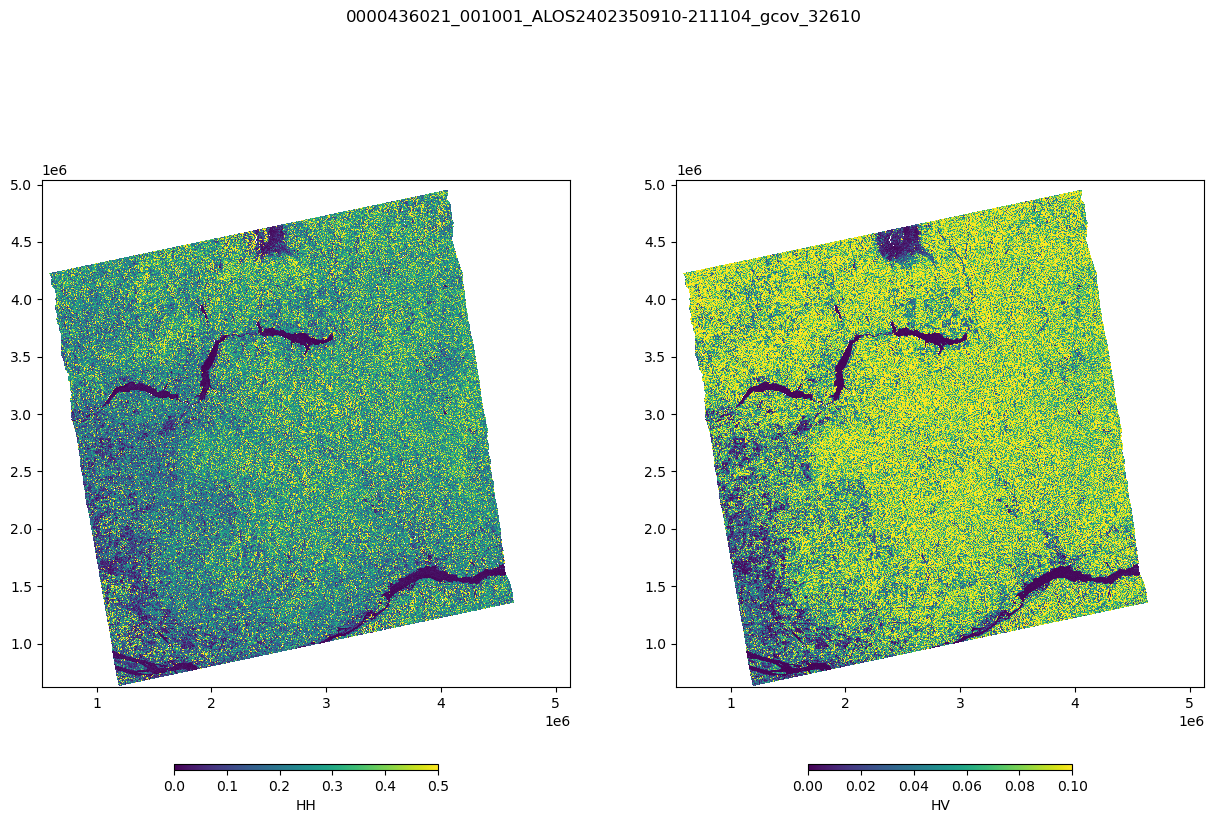

In [48]:

for NISAR_GCOV in NISAR_GCOVs[:1]:
    ALOS2_id = NISAR_GCOV.split('/')[-1][:-3]
    print('')
    print(ALOS2_id)
    f = h5py.File(f"{GCOV_dir/ALOS2_id}.h5", "r") 
    a_group_key = list(f.keys())[0]
    ds_x = f[a_group_key]['LSAR']['GCOV']['grids']['frequencyA']['xCoordinates'][()]      # returns as a h5py dataset object
    ds_y = f[a_group_key]['LSAR']['GCOV']['grids']['frequencyA']['yCoordinates'][()]      # returns as a h5py dataset object
    HH = f[a_group_key]['LSAR']['GCOV']['grids']['frequencyA']['HHHH'][()] 
    HV = f[a_group_key]['LSAR']['GCOV']['grids']['frequencyA']['HVHV'][()] 
    print('Width x Height:' , ds_x.shape, ds_y.shape)
    # ulx = x_posting * round(ds_x[0]/x_posting)
    # lrx = x_posting * round(ds_x[-1]/x_posting)
    # uly = y_posting * round(ds_y[0]/y_posting)
    # lry = y_posting * round(ds_y[-1]/y_posting)
    extent= (ds_x[0],ds_y[0],ds_x[-1],ds_y[-1]) 
    print('Top Left: ', ds_x[0],ds_y[0])
    print('Bottom Right: ', ds_x[-1],ds_y[-1])
    
    fig, [ax1,ax2] = plt.subplots(1,2,figsize = (15,10))
    im1 = ax1.imshow(HH, interpolation = 'nearest',
          extent = extent, vmin=0,vmax=0.5,cmap='viridis')
    cbar1 = plt.colorbar(im1, ax=ax1,
            shrink=0.5, orientation='horizontal',
            pad=0.1, aspect=50,label='HH')
    im2 = ax2.imshow(HV, interpolation = 'nearest',
          extent = extent, vmin=0,vmax=0.1,cmap='viridis')
    cbar2 = plt.colorbar(im2, ax=ax2,
            shrink=0.5, orientation='horizontal',
            pad=0.1, aspect=50,label='HV')
    plt.suptitle(ALOS2_id)
    plt.savefig(GCOV_dir/ (ALOS2_id + '_HH-HV.png'))


## Make an animation

In [ ]:
all_figs = [os.path.join(dirpath,f)
                for dirpath,dirnames, files in os.walk(GCOV_dir)
                for f in fnmatch.filter(files,'*.png')]
all_figs.sort()
with imageio.get_writer('%s/%s.gif' %(GCOV_dir,aoi_str),mode='I',duration=300) as writer:
    for file in all_figs:
        print(file)
        image = imageio.imread(file)
        writer.append_data(image)
        

## Clean TMP files

In [22]:
shutil.rmtree(TMP_dir) 
shutil.rmtree(ALOS2_dir)

## Move files to S3 Bucket


In [23]:
files = [os.path.join(dirpath,f)
            for dirpath,dirnames, files in os.walk(RSLC_dir)
            for f in fnmatch.filter(files,'*')]
for file in files:
    new_file = ('/').join(file.split('/')[-5:])
    command = 'aws s3 mv %s s3://nisar-st-data-ondemand/ALOS2_processed/%s' %(file,new_file)
    # print(command)
    os.system(command)
    
files = [os.path.join(dirpath,f)
            for dirpath,dirnames, files in os.walk(DEM_dir)
            for f in fnmatch.filter(files,'*')]
for file in files:
    new_file = ('/').join(file.split('/')[-5:])
    command = 'aws s3 mv %s s3://nisar-st-data-ondemand/ALOS2_processed/%s' %(file,new_file)
    # print(command)
    os.system(command)

move: ../../../scratch/alex_eco_test/Walnut_Gulch_AZ/62/620/F2-7/RSLC/0000485014_001001_ALOS2452470620-221009.h5 to s3://nisar-st-data-ondemand/ALOS2_processed/62/620/F2-7/RSLC/0000485014_001001_ALOS2452470620-221009.h5
move: ../../../scratch/alex_eco_test/Walnut_Gulch_AZ/62/620/F2-7/DEM/0000485014_001001_ALOS2452470620-221009.vrt to s3://nisar-st-data-ondemand/ALOS2_processed/62/620/F2-7/DEM/0000485014_001001_ALOS2452470620-221009.vrt
move: ../../../scratch/alex_eco_test/Walnut_Gulch_AZ/62/620/F2-7/DEM/0000485014_001001_ALOS2452470620-221009_0.tiff to s3://nisar-st-data-ondemand/ALOS2_processed/62/620/F2-7/DEM/0000485014_001001_ALOS2452470620-221009_0.tiff


In [24]:
## Command line option

######## ALOS2 SLC to NISAR RSLC
# for f in /scratch/alex_eco_test/ALOS2/southfork/*/; 
# do python /home/jovyan/isce3/share/nisar/examples/alos2_to_nisar_l1.py -i $f -o "${f%.*}".h5; 
# done

######## Get NISAR DEM
# for f in /scratch/alex_eco_test/ALOS2/southfork/rslc/*; 
# do python /home/jovyan/isce3/python/packages/nisar/workflows/stage_dem.py -p $f -o "${f%.*}".vrt; 
# done

######## NISAR RSLC to NISAR GCOV
# for f in /scratch/alex_eco_test/ALOS2/southfork/rslc/*.yaml; 
# do python /home/jovyan/isce3/python/packages/nisar/workflows/gcov.py $f; 
# done

In [23]:
GCOV_dir

PosixPath('/scratch/alex_eco_test/Yucatan_Lake_Louisiana/51/630/GCOV')

In [24]:
h5_files

NameError: name 'h5_files' is not defined